In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
# Analysis
import time
import warnings
from datetime import date, timedelta

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.plots import Hodograph, SkewT
from metpy.units import units
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import seaborn as sns

warnings.filterwarnings('ignore')

## Import Ngl with pyn_env active 
import Ngl

In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def interpolateToPressure_v2(DS, varName, pressGoals):
#     nCases = len(DSin.case.values)
#     nTimes = len(DSin.time.values)
    
#     saveOut = np.full([nTimes,len(pressGoals),1,1], np.nan)

    ## For the larger arrays, need to operate case-by-case; input to vinth2p can only be 3 or 4 dimensions. 
#     for iCase in range(nCases): 
#     DS = DSin

    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = DS.hyam.values
    hybm = DS.hybm.values
    hyai = DS.hyai.values
    hybi = DS.hybi.values

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

In [4]:
def process_camData(DS):
    ## Add evaporative fraction to DS 
    ds_EF = DS.LHFLX.values / (DS.LHFLX.values + DS.SHFLX.values)
    DS['EvapFraction'] = (('time'), np.squeeze(ds_EF))

    ## Define the actual vertical velocity skew, not just the third order moment 
    skw_W = DS.WP3_CLUBB.values / ((DS.WP2_CLUBB.values)**1.5)
    DS['Skw_W'] = (('time','ilev'), np.squeeze(skw_W))

    ## Add in TKE 
    DS['TKE']  = (('time','ilev','lat,','lon'),
                       0.5*(DS['UP2_CLUBB']+DS['VP2_CLUBB']+DS['WP2_CLUBB'])) 
    DS['TKE'].attrs['units']   = 'm2/s2'
    DS['TKE'].attrs['long_name']   = 'Turbulent Kinetic Energy'
    
    ## Add in wind speed 
    DS['WindMagnitude']  = (('time','lev','lat,','lon'),
                                    np.sqrt((DS.U.values**2.0) + (DS.V.values**2.0)) )

    DS['WindMagnitude'].attrs['units']   = 'm/s'
    DS['WindMagnitude'].attrs['long_name']   = 'Wind speed'

    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 

    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','TKE','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','WP2RTP_CLUBB','THETAL','WindMagnitude',
                          'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                          'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
                          'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
                          'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                          'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                          'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                          'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                          'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                          'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                          'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                          'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'])

    for iVar in range(len(varSels)): 
        varUnits = DS[varSels[iVar]].units
        varName  = DS[varSels[iVar]].long_name

        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)

        ## Assign attibutes 
        DS[varSels[iVar]+'_interp'].attrs['units']     = varUnits
        DS[varSels[iVar]+'_interp'].attrs['long_name'] = varName

        
    ## Resample to 30m means? 
    DS = DS.resample(time="30Min").mean()
        
    return DS

## Read in data for days of interest

In [5]:
## Extra vars I want, but they're on the h0 files instead of the h1 files (same time step, just different stream) 
addVars = np.asarray(['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                      'U10','CLDHGH','CLDLIQ','TMQ',
                      'thlp2','thlp2_bt','thlp2_cl','thlp2_dp1','thlp2_dp2','thlp2_forcing','thlp2_ma','thlp2_mc','thlp2_pd',
                      'thlp2_sf','thlp2_ta','thlp2_tp','thlp2_zt', 
                      'wp2','wp2_ac','wp2_bp','wp2_bt','wp2_cl','wp2_dp1','wp2_dp2','wp2_ma', 'wp2_pd','wp2_pr1','wp2_pr2',
                      'wp2_pr3','wp2_sf','wp2_ta','wp2_zt',
                      'wp2rcp','wp2rtp','wp2thlp','wp2thvp','wp3_on_wp2','wp3_on_wp2_zt','wprtp',
                      'wprtp2','wprtp_ac','wprtp_bp','wprtp_bt','wprtp_cl','wprtp_dp1','wprtp_enter_mfl','wprtp_exit_mfl',
                      'wprtp_forcing','wprtp_ma','wprtp_mc','wprtp_mfl','wprtp_mfl_max','wprtp_mfl_min','wprtp_pd',
                      'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_sicl','wprtp_ta','wprtp_tp','wprtp_zt',
                      'wprtpthlp','wpthlp','wpthlp2','wpthlp_ac','wpthlp_bp','wpthlp_bt','wpthlp_cl','wpthlp_dp1','wpthlp_entermfl',
                      'wpthlp_exit_mfl','wpthlp_forcing','wpthlp_ma','wpthlp_mc','wpthlp_mfl','wpthlp_mfl_max','wpthlp_mfl_min',
                      'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_sicl','wpthlp_ta','wpthlp_tp','wpthlp_zt'])


In [6]:
archiveDir = '/glade/scratch/mdfowler/archive/'

dateStrings = ['0609', '0923', '0715']
yearStrings = ['2016', '2017', '2017']
multiplVer  = ['V3',     'V4',   'V2']


for iDay in range(len(dateStrings)):

    case_mult = ['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HMGens'+yearStrings[iDay]+'_start'+dateStrings[iDay]+'_pert00/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_start'+dateStrings[iDay]+'_pert00/',
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult5_start'+dateStrings[iDay]+'_pert00/', 
                 # 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTGens'+yearStrings[iDay]+'_mult10_start'+dateStrings[iDay]+'_pert00/',
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_start'+dateStrings[iDay]+yearStrings[iDay]+'/',    #LES-based multipliers
                 'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt.HTG_LESmultipliers'+multiplVer[iDay]+'_c7eq0p75_start'+dateStrings[iDay]+yearStrings[iDay]+'/',    #C7 + LES-based multipliers
                ]

    # caseMult_names = ['HMG','HTG*01','HTG*05','HTG*10','HTG*LESvals','HTG*LESvals_c7eq0p75']
    caseMult_names = ['HMG','HTG*01','HTG*LESvals','HTG*LESvals_c7eq0p75']

    for iCase in range(len(case_mult)): 
        ## Get list of input files 
        listFiles_camh1 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h1*'))
        listFiles_camh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'atm/hist/*cam.h0*'))
        # listFiles_clmh0 = np.sort(glob.glob(archiveDir+case_mult[iCase]+'lnd/hist/*clm2.h0*'))

        ## Should only be one file per glob above (ran for two days), so just open each DS here
        iFile = 0 
        with xr.open_dataset(listFiles_camh1[iFile], decode_times=False) as multDS: 
            multDS         = cesm_correct_time(multDS)
            multDS['time'] = multDS.indexes['time'].to_datetimeindex() 

        # with xr.open_dataset(listFiles_clmh0[iFile], decode_times=True) as clm_multDS: 
        #     clm_multDS['time'] = multDS['time']



        ## Add variables as needed (some are on h0 file stream)
        for iVar in range(len(addVars)):
            varMult         = xr.open_dataset(listFiles_camh0[iFile])[addVars[iVar]]
            varMult['time'] = multDS['time']

            multDS = xr.merge([multDS, varMult])

        ## Select the second simulated day for analysis 
        iTimeStart_day2  = np.where( (multDS.time.values >= (multDS.time.values[0] + np.timedelta64(1,'D'))) & 
                                     (multDS.time.values <= (multDS.time.values[0] + np.timedelta64(2,'D'))))[0]

        multDS      = multDS.isel(time=iTimeStart_day2)
        # clm_multDS  = clm_multDS.isel(time=iTimeStart_day2)

        ## Give case attribute and combine 
        multDS     = multDS.assign_coords({"case":     caseMult_names[iCase]})
        # clm_multDS = clm_multDS.assign_coords({"case": caseMult_names[iCase]})

        if iCase==0: 
            multDS_allCases     = multDS
            # clm_multDS_allCases = clm_multDS
        else:
            multDS_allCases     = xr.concat([multDS_allCases,     multDS], "case")
            # clm_multDS_allCases = xr.concat([clm_multDS_allCases, clm_multDS], "case")

        del multDS

        print('Read in '+caseMult_names[iCase]+' case')
        
    if iDay==0:
        multDS_allDays     = multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        # clm_multDS_allDays = clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})
        
    else: 
        multDS_allDays     = xr.concat([multDS_allDays,     multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        # clm_multDS_allDays = xr.concat([clm_multDS_allDays, clm_multDS_allCases.assign_coords({"strDate": yearStrings[iDay]+'_'+dateStrings[iDay]})], "strDate")
        
    print('Done with the day: %s %s' % (yearStrings[iDay], dateStrings[iDay]))

Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals case
Read in HTG*LESvals_c7eq0p75 case
Done with the day: 2016 0609
Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals case
Read in HTG*LESvals_c7eq0p75 case
Done with the day: 2017 0923
Read in HMG case
Read in HTG*01 case
Read in HTG*LESvals case
Read in HTG*LESvals_c7eq0p75 case
Done with the day: 2017 0715


In [7]:
## Convert to local times...
# - - - - - - - - - - - - - - 
multDS_allDays_local    = multDS_allDays.copy(deep=True)

# Compute local time 
localTimes = multDS_allDays['time'].values - np.timedelta64(5,'h')

# Replace time dimension with local time
multDS_allDays_local    = multDS_allDays_local.assign_coords({"time": localTimes})



In [8]:
## Process the data

for iDay in range(len(dateStrings)):
    for iCase in range(len(caseMult_names)):
        
        selTime = np.where((multDS_allDays_local['time.year']==int(yearStrings[iDay])) & 
                           (multDS_allDays_local['time.month']==int(dateStrings[iDay][0:2])) )[0]
        
        sel_mult = process_camData( multDS_allDays_local.sel(case=caseMult_names[iCase],
                                                           strDate=multDS_allDays_local.strDate.values[iDay]).isel(time=selTime) )

        if iCase==0: 
            mult_all = sel_mult
        else:
            mult_all = xr.concat([mult_all, sel_mult], "case")

        del sel_mult
        
    if iDay==0: 
        days_all = mult_all
    else:
        days_all = xr.concat([days_all, mult_all], "strDate")
    del mult_all
    print('Done with day %i of %i' % (iDay+1, len(dateStrings) ) )

Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Done with day 1 of 3
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Done with day 2 of 3
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Beginning interpolation...
Done with day 3 of 3


In [9]:
## Select each date into individual DS 
days_all_20170716 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==7))[0]).sel(strDate='2017_0715')
days_all_20160610 = days_all.isel(time=np.where( (days_all['time.year']==2016) & (days_all['time.month']==6))[0]).sel(strDate='2016_0609')
days_all_20170924 = days_all.isel(time=np.where( (days_all['time.year']==2017) & (days_all['time.month']==9))[0]).sel(strDate='2017_0923')



## Look at budgets over ranges of hours

In [12]:
## Plot budget terms 

def wp2_budget_plot(DS,startHr,endHr,testCaseMult,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wp2_ma','wp2_ta','wp2_ac','wp2_bp','wp2_pr1','wp2_pr2','wp2_pr3','wp2_dp1','wp2_dp2','wp2_bt'] 
        
    elif levName=='levInterp':
        budgetNames = ['wp2_ma_interp','wp2_ta_interp','wp2_ac_interp','wp2_bp_interp',
                       'wp2_pr1_interp','wp2_pr2_interp','wp2_pr3_interp','wp2_dp1_interp','wp2_dp2_interp','wp2_bt_interp'] 

    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case=testCaseMult)[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   HMGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values), HTG10vars[levName].values, color=colorsList[3], label=termNames[3])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values-HMGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), HTGvars[levName].values, color=colorsList[3], label=termNames[3])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values+HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values), 
                HMGvars[levName].values, 
                color=colorsList[4], label=termNames[4])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[4]].values+HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values), 
            HTGvars[levName].values, 
            color=colorsList[4], label=termNames[4])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[4]].values+HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values), 
            HTG10vars[levName].values, 
            color=colorsList[4], label=termNames[4])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[4]].values+HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values)-np.squeeze(HMGvars[budgetNames[4]].values+HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values), 
            HTGvars[levName].values, 
            color=colorsList[4], label=termNames[4])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[4]].values+HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values)-np.squeeze(HMGvars[budgetNames[4]].values+HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values), 
            HTGvars[levName].values, 
            color=colorsList[4], label=termNames[4])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[7]].values+HMGvars[budgetNames[8]].values), 
                HMGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[7]].values+HTGvars[budgetNames[8]].values), 
                HTGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[7]].values+HTG10vars[budgetNames[8]].values), 
                HTG10vars[levName].values, 
                color=colorsList[5], label=termNames[5])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[7]].values+HTGvars[budgetNames[8]].values)-np.squeeze(HMGvars[budgetNames[7]].values+HMGvars[budgetNames[8]].values), 
                HTGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[7]].values+HTG10vars[budgetNames[8]].values)-np.squeeze(HMGvars[budgetNames[7]].values+HMGvars[budgetNames[8]].values), 
                HTGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    
    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wp2 budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wp2 budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title(testCaseMult+' wp2 budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG wp2 budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title(testCaseMult+'-HMG wp2 budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


Means computed over the inclusive period of 12 to 18.


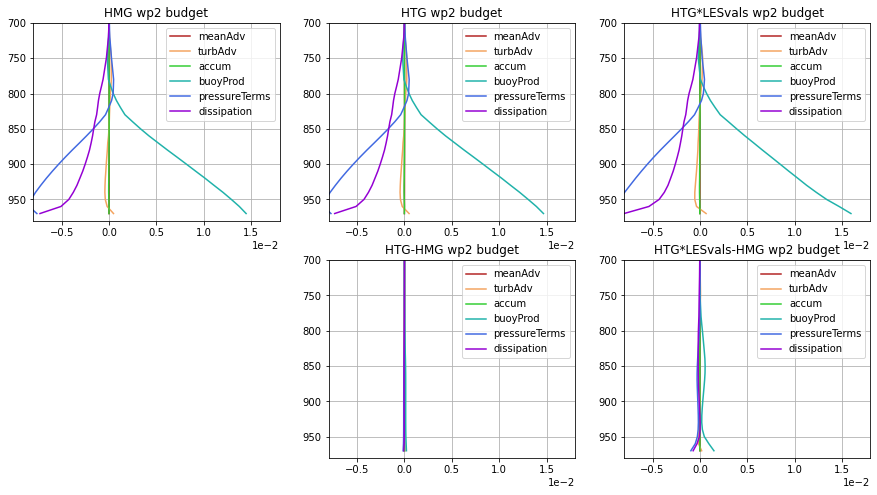

In [27]:
## Real surface:
startHr = 12
endHr   = 18
# wp2_budget_plot(days_all_20160610,startHr,endHr,'HTG*LESvals',0.015,-0.008,'levInterp')
# wp2_budget_plot(days_all_20170924,startHr,endHr,'HTG*LESvals',0.015,-0.008,'levInterp')
wp2_budget_plot(days_all_20170716,startHr,endHr,'HTG*LESvals',0.018,-0.008,'levInterp')

In [13]:
## Plot budget terms 

def wprtp_budget_plot(DS,startHr,endHr,testCaseMult,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wprtp_ma','wprtp_ta','wprtp_tp','wprtp_ac','wprtp_bp',
                       'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_dp1'] 
        
    elif levName=='levInterp':
        budgetNames = ['wprtp_ma_interp','wprtp_ta_interp','wprtp_tp_interp','wprtp_ac_interp','wprtp_bp_interp',
                       'wprtp_pr1_interp','wprtp_pr2_interp','wprtp_pr3_interp','wprtp_dp1_interp'] 
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case=testCaseMult)[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   HMGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values), HTG10vars[levName].values, color=colorsList[3], label=termNames[3])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values-HMGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), HTGvars[levName].values, color=colorsList[3], label=termNames[3])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values),   HMGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[4]].values), HTG10vars[levName].values, color=colorsList[4], label=termNames[4])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[4]].values-HMGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[4]].values-HMGvars[budgetNames[4]].values), HTGvars[levName].values, color=colorsList[4], label=termNames[4])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
                HMGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values), 
            HTG10vars[levName].values, 
            color=colorsList[5], label=termNames[5])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[8]].values),   HMGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[8]].values), HTG10vars[levName].values, color=colorsList[6], label=termNames[6])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[8]].values-HMGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[8]].values-HMGvars[budgetNames[8]].values), HTGvars[levName].values, color=colorsList[6], label=termNames[6])

    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wprtp budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title(testCaseMult+' wprtp budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG wprtp budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title(testCaseMult+'-HMG wprtp budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


Means computed over the inclusive period of 9 to 13.


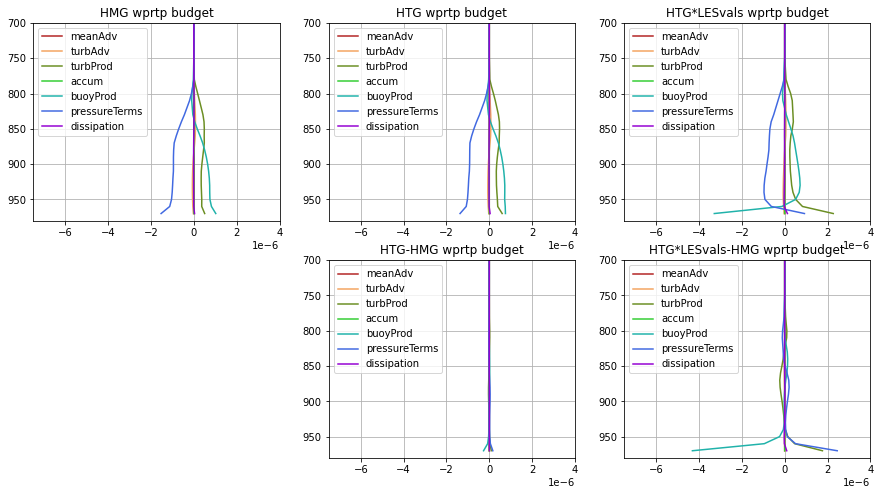

In [14]:
## Real surface:
startHr = 9
endHr   = 13
# wprtp_budget_plot(days_all_20160610,startHr,endHr,'HTG*LESvals',0.0000015,-0.0000016,'levInterp')
# wprtp_budget_plot(days_all_20170924,startHr,endHr,'HTG*LESvals',0.0000022,-0.0000022,'levInterp')
wprtp_budget_plot(days_all_20170716,startHr,endHr,'HTG*LESvals',0.000004,-0.0000075,'levInterp')

In [53]:
## Plot budget terms 

def wprtp_budget_plot(DS,startHr,endHr,testCaseMult,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wprtp_ma','wprtp_ta','wprtp_tp','wprtp_ac','wprtp_bp',
                       'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_dp1'] 
        
    elif levName=='levInterp':
        budgetNames = ['wprtp_ma_interp','wprtp_ta_interp','wprtp_tp_interp','wprtp_ac_interp','wprtp_bp_interp',
                       'wprtp_pr1_interp','wprtp_pr2_interp','wprtp_pr3_interp','wprtp_dp1_interp'] 
    elif levName=='Z3_interp':
        budgetNames = ['wprtp_ma_interp','wprtp_ta_interp','wprtp_tp_interp','wprtp_ac_interp','wprtp_bp_interp',
                       'wprtp_pr1_interp','wprtp_pr2_interp','wprtp_pr3_interp','wprtp_dp1_interp','Z3_interp'] 
        
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case=testCaseMult)[budgetNames]
        
    
    fig,axs = plt.subplots(2,1, figsize=(5,12))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[0], label=termNames[0])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[0]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[1], label=termNames[1])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[1]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[2], label=termNames[2])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[2]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[2], label=termNames[2])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[3], label=termNames[3])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[3]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[3], label=termNames[3])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[4], label=termNames[4])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[4]].values-HMGvars[budgetNames[4]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[4]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[4], label=termNames[4])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
                np.squeeze(HMGvars[budgetNames[-1]].values), 
                color=colorsList[5], label=termNames[5])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values), 
            np.squeeze(HMGvars[budgetNames[-1]].values), 
            color=colorsList[5], label=termNames[5])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[8]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[6], label=termNames[6])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[8]].values-HMGvars[budgetNames[8]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[8]].values), 
                  np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[6], label=termNames[6])

    
    
    axs[0].set_ylim([0,5000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget \n'+str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
                    ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)
    
    axs[1].set_ylim([0,5000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].legend()
    # axs[1].set_title(testCaseMult+'-HMG wprtp budget\n'+str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
    #                 ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)
    axs[1].set_title(testCaseMult+' wprtp budget\n'+str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
                    ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)

    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()

    return


Means computed over the inclusive period of 9 to 13.


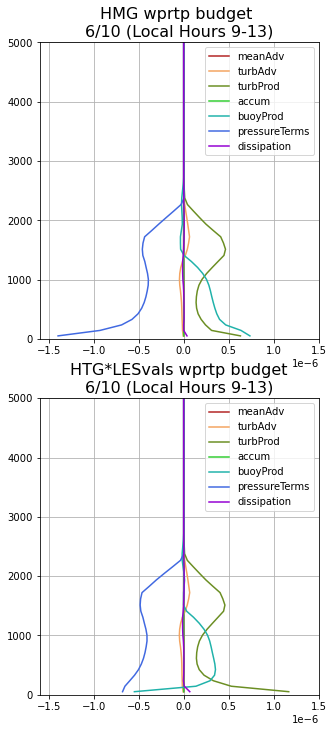

In [57]:
## Real surface:
startHr = 9
endHr   = 13
wprtp_budget_plot(days_all_20160610,startHr,endHr,'HTG*LESvals',0.0000015,-0.0000016,'Z3_interp')
# wprtp_budget_plot(days_all_20170924,startHr,endHr,'HTG*LESvals',0.000001,-0.000002,'Z3_interp')
# wprtp_budget_plot(days_all_20170716,startHr,endHr,'HTG*LESvals',0.000003,-0.0000045,'Z3_interp')


In [51]:
## Plot budget terms 

def wpthlp_budget_plot(DS,startHr,endHr,testCaseMult,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wpthlp_ma','wpthlp_ta','wpthlp_tp','wpthlp_ac','wpthlp_bp',
                       'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_dp1'] 
        
    elif levName=='levInterp':
        budgetNames = ['wpthlp_ma_interp','wpthlp_ta_interp','wpthlp_tp_interp','wpthlp_ac_interp','wpthlp_bp_interp',
                       'wpthlp_pr1_interp','wpthlp_pr2_interp','wpthlp_pr3_interp','wpthlp_dp1_interp'] 
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case=testCaseMult)[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   HMGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values), HTG10vars[levName].values, color=colorsList[3], label=termNames[3])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values-HMGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), HTGvars[levName].values, color=colorsList[3], label=termNames[3])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values),   HMGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[4]].values), HTG10vars[levName].values, color=colorsList[4], label=termNames[4])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[4]].values-HMGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[4]].values-HMGvars[budgetNames[4]].values), HTGvars[levName].values, color=colorsList[4], label=termNames[4])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
                HMGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values), 
            HTG10vars[levName].values, 
            color=colorsList[5], label=termNames[5])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[8]].values),   HMGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[8]].values), HTG10vars[levName].values, color=colorsList[6], label=termNames[6])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[8]].values-HMGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[8]].values-HMGvars[budgetNames[8]].values), HTGvars[levName].values, color=colorsList[6], label=termNames[6])

    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wpthlp budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wpthlp budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title(testCaseMult+' wpthlp budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG wpthlp budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title(testCaseMult+'-HMG wpthlp budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


Means computed over the inclusive period of 9 to 13.
Means computed over the inclusive period of 9 to 13.
Means computed over the inclusive period of 9 to 13.


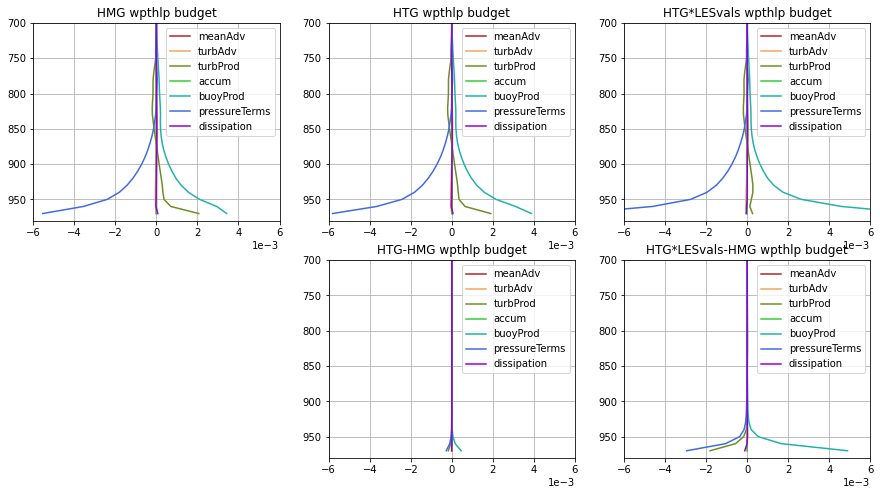

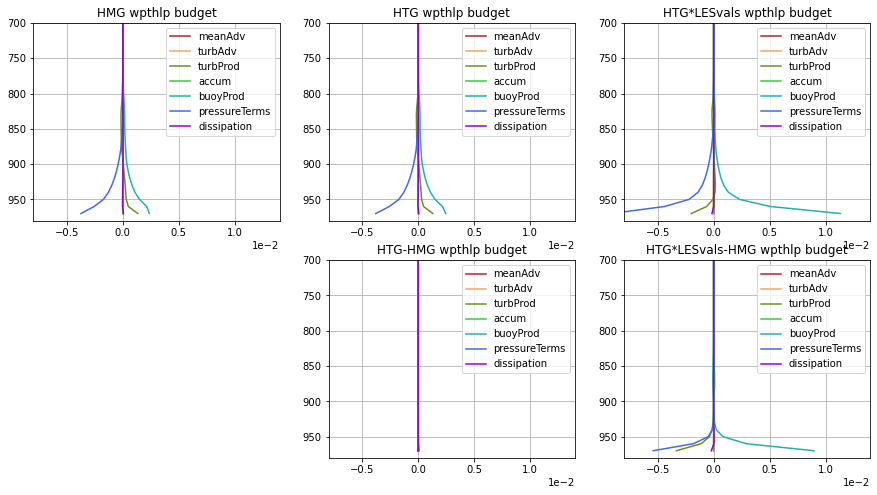

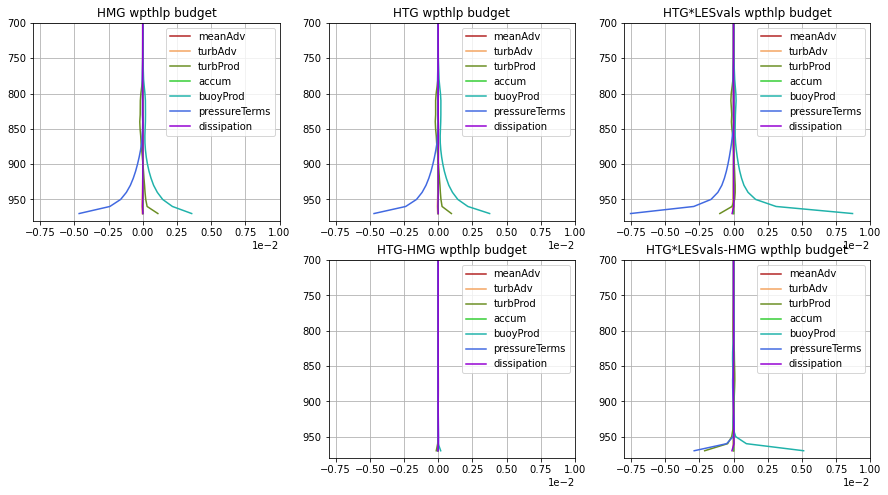

In [52]:
## Real surface:
startHr = 9
endHr   = 13
wpthlp_budget_plot(days_all_20160610,startHr,endHr,'HTG*LESvals',0.006,-0.006,'levInterp')
wpthlp_budget_plot(days_all_20170924,startHr,endHr,'HTG*LESvals',0.014,-0.008,'levInterp')
wpthlp_budget_plot(days_all_20170716,startHr,endHr,'HTG*LESvals',0.01,-0.008,'levInterp')

In [58]:
## Plot budget terms 

def wpthlp_budget_plot(DS,startHr,endHr,testCaseMult,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wpthlp_ma','wpthlp_ta','wpthlp_tp','wpthlp_ac','wpthlp_bp',
                       'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_dp1'] 
        
    elif levName=='levInterp':
        budgetNames = ['wpthlp_ma_interp','wpthlp_ta_interp','wpthlp_tp_interp','wpthlp_ac_interp','wpthlp_bp_interp',
                       'wpthlp_pr1_interp','wpthlp_pr2_interp','wpthlp_pr3_interp','wpthlp_dp1_interp'] 
        
    elif levName=='Z3_interp':
        budgetNames = ['wpthlp_ma_interp','wpthlp_ta_interp','wpthlp_tp_interp','wpthlp_ac_interp','wpthlp_bp_interp',
                       'wpthlp_pr1_interp','wpthlp_pr2_interp','wpthlp_pr3_interp','wpthlp_dp1_interp','Z3_interp'] 
        
        
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case=testCaseMult)[budgetNames]
        
    
    fig,axs = plt.subplots(2,1, figsize=(5,12))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[0], label=termNames[0])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[0]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),  
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[1], label=termNames[1])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[1]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[2], label=termNames[2])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[2]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[2], label=termNames[2])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),  
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[3], label=termNames[3])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[3]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[3], label=termNames[3])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[4], label=termNames[4])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[4]].values-HMGvars[budgetNames[4]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[4]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[4], label=termNames[4])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
                np.squeeze(HMGvars[budgetNames[-1]].values), 
                color=colorsList[5], label=termNames[5])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values), 
            np.squeeze(HMGvars[budgetNames[-1]].values), 
            color=colorsList[5], label=termNames[5])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[8]].values),   
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[6], label=termNames[6])
    # axs[1].plot( np.squeeze(HTG10vars[budgetNames[8]].values-HMGvars[budgetNames[8]].values), 
    axs[1].plot( np.squeeze(HTG10vars[budgetNames[8]].values), 
                 np.squeeze(HMGvars[budgetNames[-1]].values), color=colorsList[6], label=termNames[6])

    axs[0].set_ylim([0,5000])
    axs[0].set_xlim([xmin,xmax])
    axs[0].legend()
    axs[0].set_title('HMG wpthlp budget\n'+str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
                    ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)

    axs[1].set_ylim([0,5000])
    axs[1].set_xlim([xmin,xmax])
    axs[1].legend()
    # axs[1].set_title(testCaseMult+'-HMG wpthlp budget\n'+str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
    #                 ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)    
    axs[1].set_title(testCaseMult+' wpthlp budget\n'+str(DS['time.month'].values[0])+'/'+str(DS['time.day'].values[0])+
                    ' (Local Hours '+str(startHr)+'-'+str(endHr)+')', fontsize=16)
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    
    return


Means computed over the inclusive period of 9 to 13.


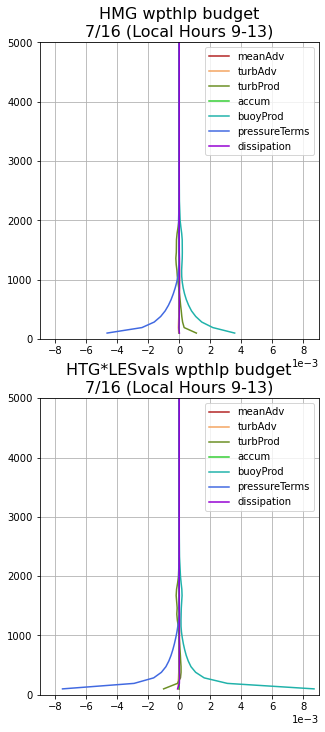

In [66]:
## Real surface:
startHr = 9
endHr   = 13
# wpthlp_budget_plot(days_all_20160610,startHr,endHr,'HTG*LESvals',0.009,-0.009,'Z3_interp')
# wpthlp_budget_plot(days_all_20170924,startHr,endHr,'HTG*LESvals',0.013,-0.01,'Z3_interp')
wpthlp_budget_plot(days_all_20170716,startHr,endHr,'HTG*LESvals',0.009,-0.009,'Z3_interp')



**Plot mean profiles in each case, averaged over sets of hours**

In [10]:
def meanProfile_plot(DS,varName,startHr,endHr,testCaseMult,xmax,xmin,ymax,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    ## Select each case
    HMGvar   = hourlyMean_DS.sel(case='HMG')[varName]
    HTGvar   = hourlyMean_DS.sel(case='HTG*01')[varName]
    HTGmultVar = hourlyMean_DS.sel(case=testCaseMult)[varName]
        
    fig,axs = plt.subplots(1,1, figsize=(5,6))
    
    colorsList = ['orangered','dodgerblue','limegreen']
    
    axs.plot( np.squeeze(HMGvar.values), HMGvar[levName].values, color='orangered', label=HMGvar.case.values )
    axs.plot( np.squeeze(HTGvar.values), HTGvar[levName].values, color='dodgerblue', label=HTGvar.case.values )
    axs.plot( np.squeeze(HTGmultVar.values), HTGmultVar[levName].values, color='limegreen', label=HTGmultVar.case.values )
    axs.legend()
    axs.set_ylim([ymax,980])
    axs.invert_yaxis()
    axs.set_xlim([xmin,xmax])
    axs.set_title(varName+' mean over hours (local) '+str(startHr)+'-'+str(endHr))
    
    return


Means computed over the inclusive period of 9 to 13.


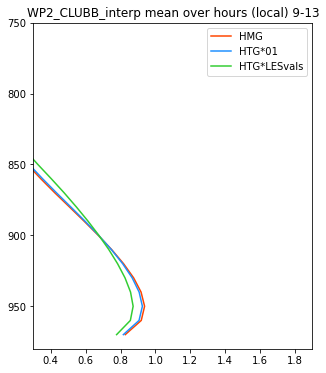

In [11]:
startHr = 9
endHr   = 13 

# meanProfile_plot(days_all_20160610,'WP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',1.9,1.2,850,'levInterp')
# meanProfile_plot(days_all_20170924,'WP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',1.6,0.0,750,'levInterp')
meanProfile_plot(days_all_20170716,'WP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',1.9,0.3,750,'levInterp')


Means computed over the inclusive period of 12 to 18.


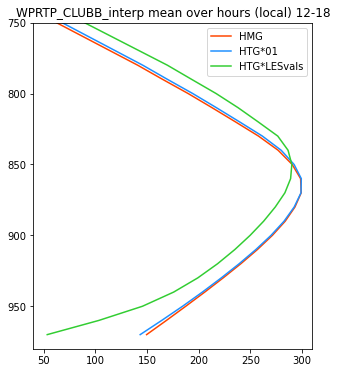

In [103]:
startHr = 12
endHr   = 18 

# meanProfile_plot(days_all_20160610,'WPRTP_CLUBB_interp',startHr,endHr,'HTG*LESvals',280,120,850,'levInterp')
# meanProfile_plot(days_all_20170924,'WPRTP_CLUBB_interp',startHr,endHr,'HTG*LESvals',230,50,750,'levInterp')
meanProfile_plot(days_all_20170716,'WPRTP_CLUBB_interp',startHr,endHr,'HTG*LESvals',310,40,750,'levInterp')


Means computed over the inclusive period of 12 to 18.


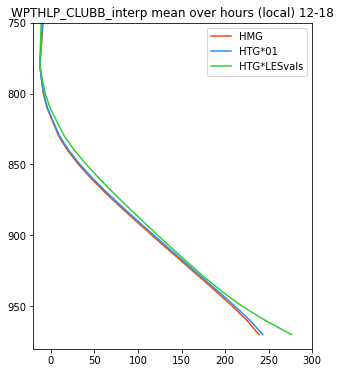

In [112]:
startHr = 12
endHr   = 18 

# meanProfile_plot(days_all_20160610,'WPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',275,50,850,'levInterp')
# meanProfile_plot(days_all_20170924,'WPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',300,-20,750,'levInterp')
meanProfile_plot(days_all_20170716,'WPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',300,-20,750,'levInterp')


Means computed over the inclusive period of 12 to 18.


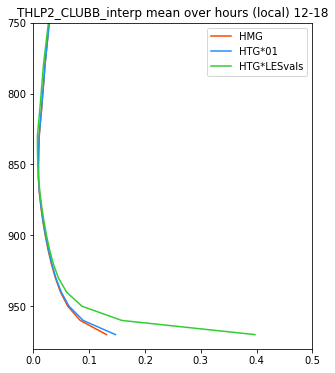

In [124]:
startHr = 12
endHr   = 18 

# meanProfile_plot(days_all_20160610,'THLP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.7,0,850,'levInterp')
# meanProfile_plot(days_all_20170924,'THLP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',1.1,0,750,'levInterp')
# meanProfile_plot(days_all_20170716,'THLP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.5,0,750,'levInterp')


Means computed over the inclusive period of 12 to 18.


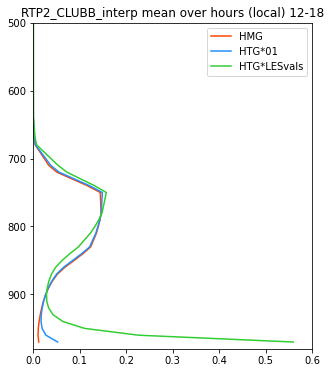

In [137]:
startHr = 12
endHr   = 18 

# meanProfile_plot(days_all_20160610,'RTP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.12,0,850,'levInterp')
# meanProfile_plot(days_all_20170924,'RTP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.16,0,400,'levInterp')
meanProfile_plot(days_all_20170716,'RTP2_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.6,0,500,'levInterp')


Means computed over the inclusive period of 12 to 18.


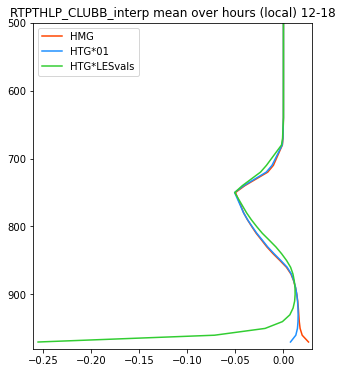

In [147]:
startHr = 12
endHr   = 18 

# meanProfile_plot(days_all_20160610,'RTPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.05,-0.1,850,'levInterp')
# meanProfile_plot(days_all_20170924,'RTPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.03,-0.14,400,'levInterp')
meanProfile_plot(days_all_20170716,'RTPTHLP_CLUBB_interp',startHr,endHr,'HTG*LESvals',0.03,-0.26,500,'levInterp')


Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.


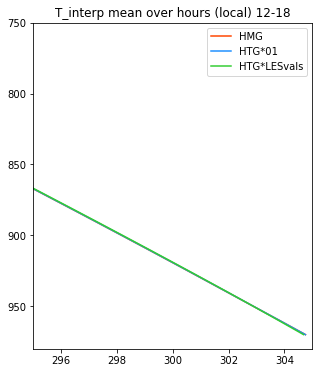

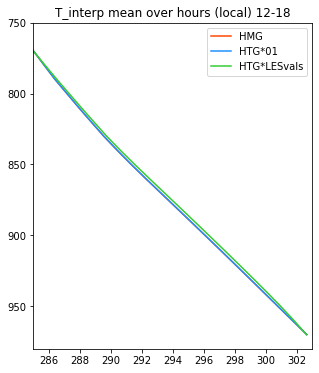

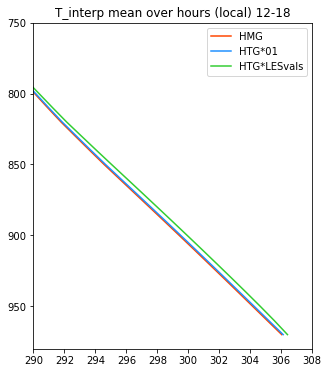

In [176]:
startHr = 12
endHr   = 18 

meanProfile_plot(days_all_20160610,'T_interp',startHr,endHr,'HTG*LESvals',305,295,750,'levInterp')
meanProfile_plot(days_all_20170924,'T_interp',startHr,endHr,'HTG*LESvals',303,285,750,'levInterp')
meanProfile_plot(days_all_20170716,'T_interp',startHr,endHr,'HTG*LESvals',308,290,750,'levInterp')


Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.


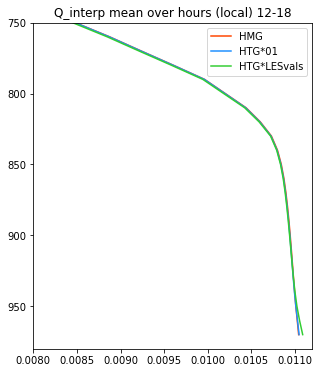

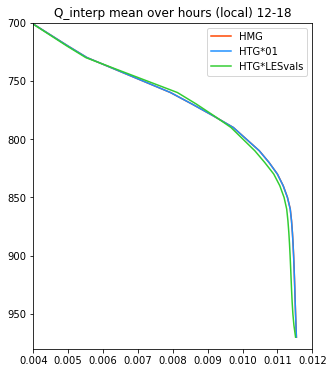

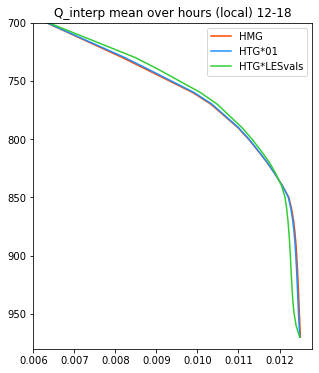

In [171]:
startHr = 12
endHr   = 18 

meanProfile_plot(days_all_20160610,'Q_interp',startHr,endHr,'HTG*LESvals',0.0112,0.008,750,'levInterp')
meanProfile_plot(days_all_20170924,'Q_interp',startHr,endHr,'HTG*LESvals',0.012,0.004,700,'levInterp')
meanProfile_plot(days_all_20170716,'Q_interp',startHr,endHr,'HTG*LESvals',0.0128,0.006,700,'levInterp')
